# PySpark

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window
from pyspark.sql.functions import UserDefinedFunction,isnan, when, count, col, isnull,month, hour,year,minute,second,lower,lit,dayofweek, to_timestamp, to_date, monotonically_increasing_id, row_number
from pyspark.sql.types import TimestampType, DateType,DoubleType,FloatType,IntegerType, StringType, StructType, StructField
from pyspark.sql import DataFrame
from functools import reduce
from pyspark.sql import functions as F
import pandas as pd
import sparkpickle
import timeit
from sklearn.metrics import confusion_matrix
from pyspark.sql.functions import to_date, udf
import dateparser
import json
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.feature import HashingTF, Tokenizer
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sc = SparkContext("local[*]", "Random Forest Models")
spark = SparkSession(sc)

# Filtered and preprocessed data

In [4]:
board_count_route4_dir1_stop12 = spark.read.csv('Data_for_RF_Models/Board_Counts/route_4/direction1/bus_stop_12/data.csv', header = True, inferSchema = True)
#board_count_route4_dir1_stop12 = pickle.load('Data_rf/board_count/direction1/route4/board_count_route4_dir1_stop12.pkl', header = True, inferSchema = True)

In [5]:
board_count_route4_dir1_stop12.show(5)

+---+-----+------------+----+-----------+-------------------+--------------------+-----------------------+
|_c0|month|service_kind|hour|board_count|          mean_temp|         mean_precip|surrounding_board_count|
+---+-----+------------+----+-----------+-------------------+--------------------+-----------------------+
|  0|    1|     weekday|   9|          0|0.06553581657095381|0.009610653308378085|     0.6160409556313993|
|  1|    1|     weekday|  10|          1|0.12748201506508317|0.021835138224994825|     0.6628744785741373|
|  2|    1|     weekday|  13|          0|0.21161440426777747| 0.01189846431969855|     0.7853621539628365|
|  3|    1|     weekday|  14|          0|0.22646844657657045|0.020642360835600296|     0.8134133006395176|
|  4|    1|     weekday|  15|          0| 0.1989162384703077| 0.01747164241023281|     0.7193899317406143|
+---+-----+------------+----+-----------+-------------------+--------------------+-----------------------+
only showing top 5 rows



In [6]:
board_count_route4_dir1_stop12 = board_count_route4_dir1_stop12.withColumnRenamed('_c0', 'index')
board_count_route4_dir1_stop12 = board_count_route4_dir1_stop12.withColumnRenamed('board_count', 'label')

In [7]:
board_count_route4_dir1_stop12.printSchema()

root
 |-- index: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- service_kind: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- mean_temp: double (nullable = true)
 |-- mean_precip: double (nullable = true)
 |-- surrounding_board_count: double (nullable = true)



In [8]:
print(board_count_route4_dir1_stop12.count(), len(board_count_route4_dir1_stop12.columns))

1397 8


In [9]:
month_ind = StringIndexer().setInputCol('month').setOutputCol('Months')
hour_ind = StringIndexer().setInputCol('hour').setOutputCol('Hours')
serv_ind = StringIndexer().setInputCol('service_kind').setOutputCol('Serv_kinds')

In [10]:
board_count_route4_dir1_stop12 = month_ind.fit(board_count_route4_dir1_stop12).transform(board_count_route4_dir1_stop12)
board_count_route4_dir1_stop12 = hour_ind.fit(board_count_route4_dir1_stop12).transform(board_count_route4_dir1_stop12)
board_count_route4_dir1_stop12 = serv_ind.fit(board_count_route4_dir1_stop12).transform(board_count_route4_dir1_stop12)

In [11]:
board_count_route4_dir1_stop12 = board_count_route4_dir1_stop12.drop('month')
board_count_route4_dir1_stop12 = board_count_route4_dir1_stop12.drop('hour')
board_count_route4_dir1_stop12 = board_count_route4_dir1_stop12.drop('service_kind')

In [12]:
board_count_route4_dir1_stop12.show(5)

+-----+-----+-------------------+--------------------+-----------------------+------+-----+----------+
|index|label|          mean_temp|         mean_precip|surrounding_board_count|Months|Hours|Serv_kinds|
+-----+-----+-------------------+--------------------+-----------------------+------+-----+----------+
|    0|    0|0.06553581657095381|0.009610653308378085|     0.6160409556313993|   1.0| 10.0|       0.0|
|    1|    1|0.12748201506508317|0.021835138224994825|     0.6628744785741373|   1.0|  3.0|       0.0|
|    2|    0|0.21161440426777747| 0.01189846431969855|     0.7853621539628365|   1.0|  2.0|       0.0|
|    3|    0|0.22646844657657045|0.020642360835600296|     0.8134133006395176|   1.0|  0.0|       0.0|
|    4|    0| 0.1989162384703077| 0.01747164241023281|     0.7193899317406143|   1.0|  1.0|       0.0|
+-----+-----+-------------------+--------------------+-----------------------+------+-----+----------+
only showing top 5 rows



In [13]:
board_count_route4_dir1_stop12.printSchema()

root
 |-- index: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- mean_temp: double (nullable = true)
 |-- mean_precip: double (nullable = true)
 |-- surrounding_board_count: double (nullable = true)
 |-- Months: double (nullable = false)
 |-- Hours: double (nullable = false)
 |-- Serv_kinds: double (nullable = false)



## Encoding Categorical Variables

In [14]:
encoder = OneHotEncoder(inputCols = ['Months', 'Hours', 'Serv_kinds'], outputCols = ['Months_Cat', 'Hours_Cat', 'Serv_kinds_Cat'])

In [15]:
model = encoder.fit(board_count_route4_dir1_stop12)
dt = model.transform(board_count_route4_dir1_stop12)
dt = dt.drop('Months')
dt = dt.drop('Hours')
dt = dt.drop('Serv_kinds')
dt.show(5)

+-----+-----+-------------------+--------------------+-----------------------+--------------+---------------+--------------+
|index|label|          mean_temp|         mean_precip|surrounding_board_count|    Months_Cat|      Hours_Cat|Serv_kinds_Cat|
+-----+-----+-------------------+--------------------+-----------------------+--------------+---------------+--------------+
|    0|    0|0.06553581657095381|0.009610653308378085|     0.6160409556313993|(11,[1],[1.0])|(17,[10],[1.0])| (1,[0],[1.0])|
|    1|    1|0.12748201506508317|0.021835138224994825|     0.6628744785741373|(11,[1],[1.0])| (17,[3],[1.0])| (1,[0],[1.0])|
|    2|    0|0.21161440426777747| 0.01189846431969855|     0.7853621539628365|(11,[1],[1.0])| (17,[2],[1.0])| (1,[0],[1.0])|
|    3|    0|0.22646844657657045|0.020642360835600296|     0.8134133006395176|(11,[1],[1.0])| (17,[0],[1.0])| (1,[0],[1.0])|
|    4|    0| 0.1989162384703077| 0.01747164241023281|     0.7193899317406143|(11,[1],[1.0])| (17,[1],[1.0])| (1,[0],[1.0])|


## Random Partition into Training and Test Sets

In [16]:
(trainingData, ValidationSet) = dt.randomSplit([0.8, 0.2], seed = 123)

In [17]:
trainingData.show()

+-----+-----+-------------------+--------------------+-----------------------+--------------+---------------+--------------+
|index|label|          mean_temp|         mean_precip|surrounding_board_count|    Months_Cat|      Hours_Cat|Serv_kinds_Cat|
+-----+-----+-------------------+--------------------+-----------------------+--------------+---------------+--------------+
|    0|    0|0.06553581657095381|0.009610653308378085|     0.6160409556313993|(11,[1],[1.0])|(17,[10],[1.0])| (1,[0],[1.0])|
|    1|    1|0.12748201506508317|0.021835138224994825|     0.6628744785741373|(11,[1],[1.0])| (17,[3],[1.0])| (1,[0],[1.0])|
|    3|    0|0.22646844657657045|0.020642360835600296|     0.8134133006395176|(11,[1],[1.0])| (17,[0],[1.0])| (1,[0],[1.0])|
|    4|    0| 0.1989162384703077| 0.01747164241023281|     0.7193899317406143|(11,[1],[1.0])| (17,[1],[1.0])| (1,[0],[1.0])|
|    5|    1| 0.1989162384703077| 0.01747164241023281|     0.7193899317406143|(11,[1],[1.0])| (17,[1],[1.0])| (1,[0],[1.0])|


In [18]:
ValidationSet.show()

+-----+-----+-------------------+--------------------+-----------------------+--------------+---------------+--------------+
|index|label|          mean_temp|         mean_precip|surrounding_board_count|    Months_Cat|      Hours_Cat|Serv_kinds_Cat|
+-----+-----+-------------------+--------------------+-----------------------+--------------+---------------+--------------+
|    2|    0|0.21161440426777747| 0.01189846431969855|     0.7853621539628365|(11,[1],[1.0])| (17,[2],[1.0])| (1,[0],[1.0])|
|    6|    0| 0.1989162384703077| 0.01747164241023281|     0.7193899317406143|(11,[1],[1.0])| (17,[1],[1.0])| (1,[0],[1.0])|
|   12|    0|0.12748201506508317|0.021835138224994825|     0.6628744785741373|(11,[1],[1.0])| (17,[3],[1.0])| (1,[0],[1.0])|
|   13|    2|0.12748201506508317|0.021835138224994825|     0.6628744785741373|(11,[1],[1.0])| (17,[3],[1.0])| (1,[0],[1.0])|
|   18|    3|0.12748201506508317|0.021835138224994825|     0.6628744785741373|(11,[1],[1.0])| (17,[3],[1.0])| (1,[0],[1.0])|


### Data for Classification

In [19]:
trainingData_clf = trainingData.withColumn('label', when(trainingData.label > 0, 1) \
                                           .otherwise(0))

In [20]:
trainingData_clf.show()

+-----+-----+-------------------+--------------------+-----------------------+--------------+---------------+--------------+
|index|label|          mean_temp|         mean_precip|surrounding_board_count|    Months_Cat|      Hours_Cat|Serv_kinds_Cat|
+-----+-----+-------------------+--------------------+-----------------------+--------------+---------------+--------------+
|    0|    0|0.06553581657095381|0.009610653308378085|     0.6160409556313993|(11,[1],[1.0])|(17,[10],[1.0])| (1,[0],[1.0])|
|    1|    1|0.12748201506508317|0.021835138224994825|     0.6628744785741373|(11,[1],[1.0])| (17,[3],[1.0])| (1,[0],[1.0])|
|    3|    0|0.22646844657657045|0.020642360835600296|     0.8134133006395176|(11,[1],[1.0])| (17,[0],[1.0])| (1,[0],[1.0])|
|    4|    0| 0.1989162384703077| 0.01747164241023281|     0.7193899317406143|(11,[1],[1.0])| (17,[1],[1.0])| (1,[0],[1.0])|
|    5|    1| 0.1989162384703077| 0.01747164241023281|     0.7193899317406143|(11,[1],[1.0])| (17,[1],[1.0])| (1,[0],[1.0])|


### Data for Regression

In [21]:
trainingData_reg = trainingData.filter(trainingData.label > 0)

In [22]:
trainingData_reg.show()

+-----+-----+-------------------+--------------------+-----------------------+--------------+---------------+--------------+
|index|label|          mean_temp|         mean_precip|surrounding_board_count|    Months_Cat|      Hours_Cat|Serv_kinds_Cat|
+-----+-----+-------------------+--------------------+-----------------------+--------------+---------------+--------------+
|    1|    1|0.12748201506508317|0.021835138224994825|     0.6628744785741373|(11,[1],[1.0])| (17,[3],[1.0])| (1,[0],[1.0])|
|    5|    1| 0.1989162384703077| 0.01747164241023281|     0.7193899317406143|(11,[1],[1.0])| (17,[1],[1.0])| (1,[0],[1.0])|
|   14|    1|0.21161440426777747| 0.01189846431969855|     0.7853621539628365|(11,[1],[1.0])| (17,[2],[1.0])| (1,[0],[1.0])|
|   15|    1| 0.1989162384703077| 0.01747164241023281|     0.7193899317406143|(11,[1],[1.0])| (17,[1],[1.0])| (1,[0],[1.0])|
|   20|    1|0.22646844657657045|0.020642360835600296|     0.8134133006395176|(11,[1],[1.0])| (17,[0],[1.0])| (1,[0],[1.0])|


In [23]:
#testData_reg = testData.filter(testData.label > 0)
#testData_reg2 = testData.toPandas()
#testData_reg2 = testData_reg2[testData_reg2['index'].isin(clf_predictions[clf_predictions['label_clf'] == 1].index.values)]
#testData_reg2.head()

In [24]:
#testData_reg2a = spark.createDataFrame(testData_reg2)

### Subordinate Functions

In [34]:
def paste0(ss,sep=None,na_rep=None,):
            '''Analogy to R paste0'''
            ss = [pd.Series(s) for s in ss]
            ss = [s.astype(str) for s in ss]
            s = ss[0]
            res = s.str.cat(ss[1:],sep=sep,na_rep=na_rep)
            return res

# Classification by Random Forest

## Label and Features

In [26]:
feature_list = []
for col in trainingData_clf.columns[1:8]:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

In [27]:
assembler = VectorAssembler(inputCols = feature_list, outputCol = "features")

In [28]:
rf_clf = RandomForestClassifier(labelCol = "label", featuresCol = "features")

In [29]:
pipeline = Pipeline(stages=[assembler, rf_clf])

In [30]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf_clf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 110, num = 15)]) \
    .addGrid(rf_clf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 30, num = 6)]) \
    .build()

In [31]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

In [32]:
tic = timeit.default_timer()

cv_clf_Model = crossval.fit(trainingData_clf)

toc = timeit.default_timer()

processing_time_min = (toc - tic)/60

In [33]:
processing_time_min

25.6466008897

In [45]:
cv_clf_Model.write().overwrite().save('RF_Models/Board_Counts/route_4/direction1/clf_bus_stop_12/')

## Model Tuning

In [37]:
# Feature importance
bestPipeline_clf = cv_clf_Model.bestModel
bestModel_clf = bestPipeline_clf.stages[1]


# Best hyperparameters
print('numTrees - ', bestModel_clf.getNumTrees)
print('maxDepth - ', bestModel_clf.getOrDefault('maxDepth'))

numTrees -  45
maxDepth -  5


In [38]:
feature_list

['mean_temp',
 'mean_precip',
 'surrounding_board_count',
 'Months_Cat',
 'Hours_Cat',
 'Serv_kinds_Cat']

Text(0.5, 1.0, 'Feature Importances')

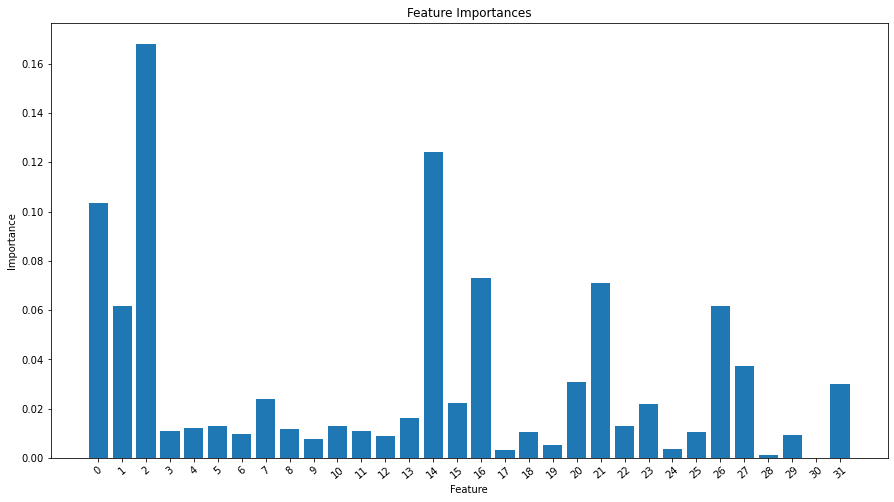

In [39]:
# Feature importance
bestPipeline_clf = cv_clf_Model.bestModel
bestModel_clf = bestPipeline_clf.stages[1]

importances_clf = bestModel_clf.featureImportances

x_values = list(range(len(importances_clf)))
plt.figure(figsize = (15,8))

plt.bar(x_values, importances_clf, orientation = 'vertical')
plt.xticks(x_values, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

# Regression by Random Forest

## Training Data for Regression

In [40]:
feature_list_reg = []
for col in trainingData_reg.columns[1:8]:
    if col == 'label':
        continue
    else:
        feature_list_reg.append(col)

In [41]:
assembler_reg = VectorAssembler(inputCols = feature_list_reg, outputCol = "features")

In [42]:
rf_reg = RandomForestRegressor(labelCol="label", featuresCol="features")

In [43]:
pipeline_reg = Pipeline(stages=[assembler_reg, rf_reg])

In [53]:
#ParamGrid = ParamGridBuilder() \
#    .addGrid(rf_reg.numTrees, [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]) \
#    .addGrid(rf_reg.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 30, num = 6)]) \
#    .build()

In [41]:
crossval_reg = CrossValidator(estimator=pipeline_reg,
                              estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(),
                              numFolds=5)

In [42]:
tic = timeit.default_timer()

cv_reg_Model = crossval_reg.fit(trainingData_reg)

toc = timeit.default_timer()

processing2_time_min = (toc - tic)/60

In [43]:
processing2_time_min

2.88089830231667

# Combining the two models

In [ ]:
predictions_clf = cv_clf_Model.transform(ValidationSet)

In [ ]:
clf_predictions = clf_Model_predictions[['index', 'label', 'prediction']].toPandas()
clf_predictions.columns = ['index', 'board_count', 'prediction_clf']

##### Extract predicted counts for regression:

In [ ]:
index_reg = clf_predictions[clf_predictions['prediction_clf'] == 1].index.values
ValidationSet_pd = ValidationSet.toPandas()

In [ ]:
ValidationData_reg = ValidationSet_pd[ValidationSet_pd['index'].isin(index_reg)]

##### Prepare data for regression: 'From Pandas back to pyspark'

In [ ]:
ValidationSet2 = spark.createDataFrame(ValidationData_reg)

##### Predict counts:

In [ ]:
predictions_reg = cv_reg_Model.transform(ValidationSet2)
predictions_reg_data = predictions_reg[['index', 'prediction', 'label']].toPandas()
predictions_reg_data.columns = ['index', 'prediction_reg', 'label_reg']

## Combine predictions:

In [ ]:
Predictions = pd.merge(clf_predictions, predictions_reg_data, on = 'index', how = 'left')
Predictions['Predictions'] = np.where(Predictions['prediction_clf'] == 1, Predictions['prediction_reg'], 0)

In [85]:
predictions_reg = cv_reg_Model.transform(ValidationSet_spark)

In [86]:
predictions_reg = predictions_reg[['index', 'prediction', 'label']].toPandas()
predictions_reg.columns = ['index', 'prediction_reg', 'board_count']
predictions_reg.head()

,index,prediction_reg,board_count
0,30,3.218319,0
1,34,1.927962,4
2,47,1.238692,2
3,157,1.429990,0
4,193,1.616301,0


In [88]:
predictions_reg.shape

(11, 3)

In [89]:
Predictions = pd.merge(predictions_clf_data, predictions_reg, on = 'index', how = 'left')
Predictions.head()

,index,prediction_clf,label_clf,prediction_reg,board_count
0,2,0.0,0,NaN,NaN
1,6,0.0,0,NaN,NaN
2,12,0.0,0,NaN,NaN
3,13,0.0,2,NaN,NaN
4,18,0.0,3,NaN,NaN


In [91]:
Predictions['Predictions'] = np.where(Predictions['prediction_clf'] == 1, Predictions['prediction_reg'], 0)
Predictions['board_count'] = ValidationSet_pd['label']
Predictions.head()

,index,prediction_clf,label_clf,prediction_reg,board_count,Predictions
0,2,0.0,0,NaN,0,0.0
1,6,0.0,0,NaN,0,0.0
2,12,0.0,0,NaN,0,0.0
3,13,0.0,2,NaN,2,0.0
4,18,0.0,3,NaN,3,0.0


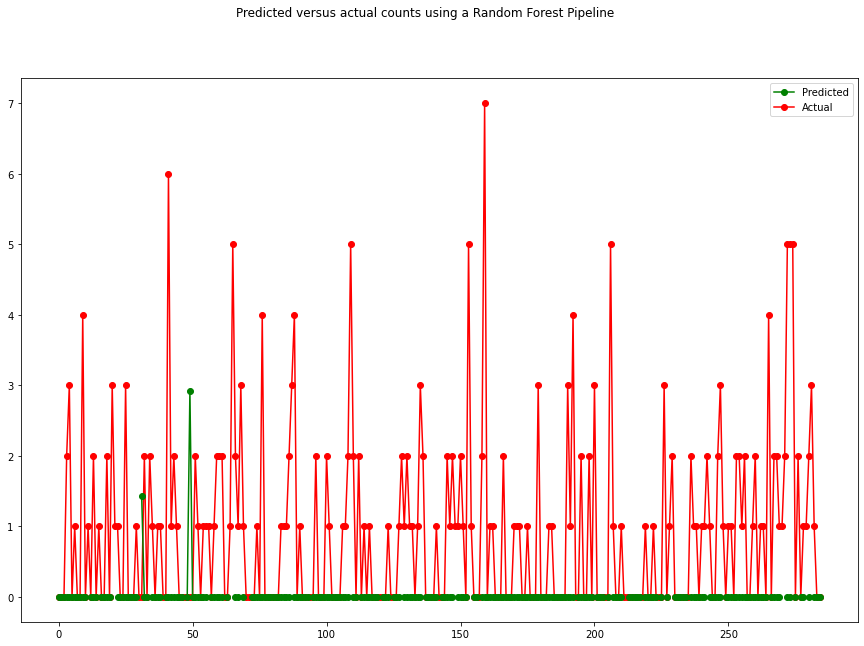

In [92]:
fig = plt.figure(figsize = (15,10))
fig.suptitle('Predicted versus actual counts using a Random Forest Pipeline')
actual, = plt.plot(Predictions.index, Predictions.board_count, 'ro-', label='Actual')
predicted, = plt.plot(Predictions.index, Predictions.Predictions, 'go-', label='Predicted')
plt.legend(handles=[predicted, actual])
plt.show()

Text(0.5, 1.0, 'Feature Importances')

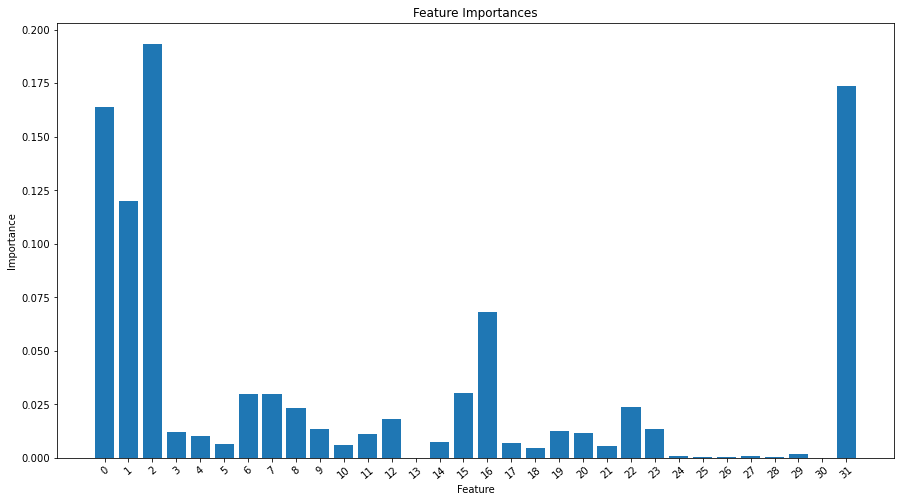

In [45]:
# Feature importance
bestPipeline_reg = cv_reg_Model.bestModel
bestModel_reg = bestPipeline_reg.stages[1]

importances_reg = bestModel_reg.featureImportances

x_values = list(range(len(importances_reg)))
plt.figure(figsize = (15,8))

plt.bar(x_values, importances_reg, orientation = 'vertical')
plt.xticks(x_values, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [47]:
# Best hyperparameters
print('numTrees - ', bestModel_reg.getNumTrees)
print('maxDepth - ', bestModel_reg.getOrDefault('maxDepth'))

numTrees -  20
maxDepth -  5


# Complete function

In [50]:
def rand_forest_pipeline(DF, route, direction, bus_stop):
    
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
    from pyspark.ml.regression import RandomForestRegressor
    from pyspark.ml.classification import RandomForestClassifier
    from pyspark.ml.evaluation import RegressionEvaluator
    from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    from pyspark.mllib.evaluation import BinaryClassificationMetrics
    from pyspark.sql import DataFrame
    
    DF = DF.withColumnRenamed('_c0', 'index')
    DF = DF.withColumnRenamed('board_count', 'label')
       
    month_ind = StringIndexer().setInputCol('month').setOutputCol('Months')
    hour_ind = StringIndexer().setInputCol('hour').setOutputCol('Hours')
    serv_ind = StringIndexer().setInputCol('service_kind').setOutputCol('Serv_kinds')
    
    DF = month_ind.fit(DF).transform(DF)
    DF = hour_ind.fit(DF).transform(DF)
    DF = serv_ind.fit(DF).transform(DF)
    
    DF = DF.drop('month')
    DF = DF.drop('hour')
    DF = DF.drop('service_kind')
    
    encoder = OneHotEncoder(inputCols = ['Months', 'Hours', 'Serv_kinds'], outputCols = ['Months_Cat', 'Hours_Cat', 'Serv_kinds_Cat'])
    
    model = encoder.fit(board_count_route4_dir1_stop12)
    dt = model.transform(board_count_route4_dir1_stop12)
    dt = dt.drop('Months')
    dt = dt.drop('Hours')
    dt = dt.drop('Serv_kinds')
    
    (trainingData, ValidationSet) = dt.randomSplit([0.8, 0.2], seed = 123)
             
    #-------------------------------------------------------------------------------------------------------------
    # Required function to save the models:
    
    def paste0(ss,sep=None,na_rep=None,):
            '''Analogy to R paste0'''
            ss = [pd.Series(s) for s in ss]
            ss = [s.astype(str) for s in ss]
            s = ss[0]
            res = s.str.cat(ss[1:],sep=sep,na_rep=na_rep)
            return res
    
    
    file_path = paste0([paste0([paste0(['RF_Models', 'Board_Counts'], sep ='/'), 
                                    paste0(['route', route], sep = '_')], sep = '/'), 
                            paste0([paste0(['direction', direction]),
                                    paste0(['bus_stop', bus_stop], sep = '_')], sep = '/')], sep = '/')
    
    file_name_clf = paste0(['clf', 'model'], sep = '_')
    file_name_reg = paste0(['reg', 'model'], sep = '_')
    
    complete_path_clf = paste0([file_path, file_name_clf], sep = '/')[0]
    complete_path_reg = paste0([file_path, file_name_reg], sep = '/')[0]
    #-------------------------------------------------------------------------------------------------------------
    # Classification
    
    ## Data preparation:
    
    trainingData_clf = trainingData.withColumn('label', when(trainingData.label > 0, 1) \
                                               .otherwise(0))
       
    feature_list = []
    for col in trainingData_clf.columns:
        if col == 'label':
            continue
        else:
            feature_list.append(col)
            
            
    assembler = VectorAssembler(inputCols=feature_list, outputCol="features")
    
    ## Random Forest Classifier:
    
    rf_clf = RandomForestClassifier(labelCol="label", featuresCol="features")
    
    pipeline = Pipeline(stages=[assembler, rf_clf])
    
    paramGrid = ParamGridBuilder() \
        .addGrid(rf_clf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]) \
        .addGrid(rf_clf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 6)]) \
        .build()
    
    crossval = CrossValidator(estimator = pipeline,
                              estimatorParamMaps = paramGrid,
                              evaluator = BinaryClassificationEvaluator(),
                              numFolds = 5)
    
    ### Train Model:
    
    cv_clf_Model = crossval.fit(trainingData_clf)
    
    #### Save trained model:
    cv_clf_Model.write().overwrite().save(complete_path_clf)
    
    #--------------------------------------------------------------------------------------------------
    # Regression
    
    ## Data preparation:
    
    trainingData_reg = spark.createDataFrame(trainingData.filter(trainingData.label > 0).collect())
        
    feature_list_reg = []
    for col in trainingData_reg.columns[1:8]:
        if col == 'label':
            continue
        else:
            feature_list_reg.append(col)
            
    assembler_reg = VectorAssembler(inputCols = feature_list_reg, outputCol = "features")
        
    ## Random Forest Regression:
    
    rf_reg = RandomForestRegressor(labelCol="label", featuresCol="features")
    pipeline_reg = Pipeline(stages=[assembler_reg, rf_reg])
    
    paramGrid = ParamGridBuilder() \
        .addGrid(rf_reg.numTrees, [int(x) for x in np.linspace(start = 10, stop = 100, num = 3)]) \
        .addGrid(rf_reg.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 5)]) \
        .build()
    
    crossval_reg = CrossValidator(estimator=pipeline_reg,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=RegressionEvaluator(),
                                  numFolds=5)
    ### Train Model:
    
    cv_reg_Model = crossval_reg.fit(trainingData_reg)
    
    #### Save trained model:
    cv_reg_Model.write().overwrite().save(complete_path_reg)
    
    #------------------------------------------------------------------------------------------------
    ### Test Combined Models:
    
    #### Classification:
    
       
    ##### Predict zeros and counts:
    
    clf_Model_predictions = cv_clf_Model.transform(ValidationSet)
    
    clf_predictions = clf_Model_predictions[['index', 'label', 'prediction']].toPandas()
    clf_predictions.columns = ['index', 'board_count', 'prediction_clf']
    
    #### Regression:
    
    ##### Extract predicted counts for regression:
    
    index_reg = clf_predictions[clf_predictions['prediction_clf'] == 1].index.values
    
    ValidationSet_pd = ValidationSet.toPandas()
    
    ValidationData_reg = ValidationSet_pd[ValidationSet_pd['index'].isin(index_reg)]
    
    ##### Prepare data for regression: 'From Pandas back to pyspark'
    
    ValidationSet2 = spark.createDataFrame(ValidationData_reg)
    
    ##### Predict counts:
    
    predictions_reg = cv_reg_Model.transform(ValidationSet2)
    
    predictions_reg_data = predictions_reg[['index', 'prediction', 'label']].toPandas()
    predictions_reg_data.columns = ['index', 'prediction_reg', 'label_reg']
    
    #------------------------------------------------------------------------------------------------------
    # Combine predictions:
    
    Predictions = pd.merge(clf_predictions, predictions_reg_data, on = 'index', how = 'left')
    Predictions['Predictions'] = np.where(Predictions['prediction_clf'] == 1, Predictions['prediction_reg'], 0)
                              
    return(Predictions)

In [190]:
#spark.udf.register(name = 'rand_forest_pipeline', f = rand_forest_pipeline)

In [48]:
board_count_route4_dir1_stop1351 = spark.read.csv('Data_for_RF_Models/Board_Counts/route_4/direction1/bus_stop_1351/data.csv', header = True, inferSchema = True)

In [ ]:
pred_route4_dir1_stop1351 = rand_forest_pipeline(board_count_route4_dir1_stop1351, '4', '1', '1351')

In [ ]:
pred_route4_dir1_stop1351.head()

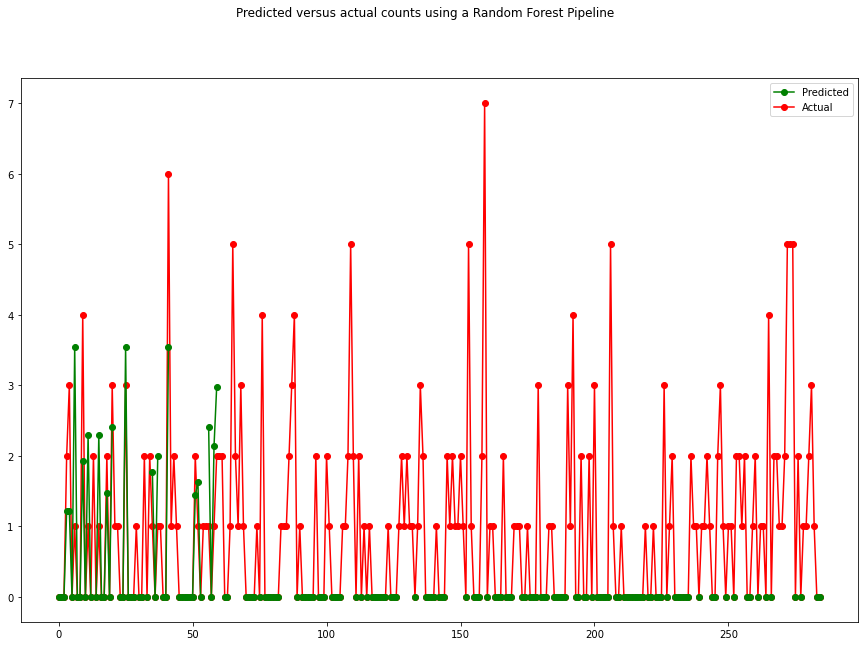

In [134]:
fig = plt.figure(figsize = (15,10))
fig.suptitle('Predicted versus actual counts using a Random Forest Pipeline')
actual, = plt.plot(pred_route4_dir1_stop1351.index, pred_route4_dir1_stop1351.board_count, 'ro-', label='Actual')
predicted, = plt.plot(pred_route4_dir1_stop1351.index, pred_route4_dir1_stop1351.Predictions, 'go-', label='Predicted')
plt.legend(handles=[predicted, actual])
plt.show()